In [1]:
import numpy as np
import pandas as pd

import requests
import json

## Step 1: Data acquisition

### For this step we will use two APIs to get page views and page counts:

- **Legacy API:** This API helps collect page counts from two different sites mobile and desktop within a range
- **Pageview API:** This API helps collect page views from three access sites mobile-web, mobile-application, and desktop.

### In the cell below we have defined these API endpoints with three alterable variables each
- **site :** the site for pagecount (mobile/desktop)
- **access :** the acces-site for pageview (mobile app/ mobile web/ desktop)
- **start :** start date in the format yyyymmddhh
- **end :** end date in the format yyyymmddhh

In [2]:
root_url = "https://wikimedia.org/api/rest_v1/metrics/"
legacy_api= root_url + 'legacy/pagecounts/aggregate/en.wikipedia.org/{site}/monthly/{start}/{end}'
pageview_api = root_url + 'pageviews/aggregate/en.wikipedia.org/{access}/user/monthly/{start}/{end}'

### Now we will define a function get_data() that uses these pre-defined endpoints to get the data in json format with requests

In [3]:
def get_data(api_type,access_site,start,end):
    """
    function that returns data for an API type, access/site for that API, in a specific range
    
    api_type: Can have the values "legacy" or "pageview" to choose a specific API endpoint
    access_site: site type for legacy API(mobile-site, desktop-site), 
                 access type for pageview API(mobile-app,mobile-web,desktop)
    start: start date in yyyymmddhh format
    end: end date in yyyymmddhh format
    
    returns: data in .json format
    """
    if api_type == "legacy":
        site = access_site
        data = requests.get(legacy_api.format(site=site,start=start,end=end)) #Setting variables in the api url and getting data
    elif api_type == "pageview":
        access = access_site
        data = requests.get(pageview_api.format(access=access,start=start,end=end)) #Setting variables in the api url and getting data
    return data
    

### Once we have this data we will need to write into a .json file, to this end we will write a function write_file() that does the same

In [4]:
def write_file(data, filename):
    """
    Function to write .json data into a .json file locally
    
    data: .json data to be written into the file
    filename: file name in which the data will be written
    """
    data_s= json.dumps(data, indent=2)
    with open(filename, "w") as f:
        f.write(data_s)
    

### Now we will implement these functions to get both Page view and Page counts for all access and site types:

- ### Legacy page counts

    The following cells collect legacy page count data from mobile-site and desktop-site from Jan 2008 to August 2019, and write this data into the corresponding .json file locally.

In [5]:
legacy_data_mobile = get_data("legacy",'mobile-site',"2008010100", "2019080100")
write_file(legacy_data_mobile.json(),"legacy_mobile-site_200801-201908.json")

In [6]:
legacy_data_desktop = get_data("legacy",'desktop-site',"2008010100", "2019080100")
write_file(legacy_data_desktop.json(),"legacy_desktop-site_200801-201908.json")

- ### Page views

    The following cells collect page view data from mobile-app, mobile-web and desktop access-sites from Jan 2008 to August 2019, and write this data into the corresponding .json file locally.

In [7]:
pageview_data_mobilew = get_data("pageview",'mobile-web',"2008010100", "2019080100")
write_file(pageview_data_mobilew.json(),"pageview_mobile-web_200801-201908.json")

In [8]:
pageview_data_mobilea = get_data("pageview",'mobile-app',"2008010100", "2019080100")
write_file(pageview_data_mobilea.json(),"pageview_mobile-app_200801-201908.json")


In [9]:
pageview_data_desktop = get_data("pageview",'desktop',"2008010100", "2019080100")
write_file(pageview_data_desktop.json(),"pageview_desktop_200801-201908.json")

## Step 2: Data Processing

### In this step we shall read this json data into data frames and manipulate them so that they fit our requirements, and write this new altered data frame into a .csv file

### In the following cell we have defined a function read_file() that reads json data from a .json file, loads it into a data frame and drops unnecessary columns, only returning timestamp and count values.

In [10]:
def read_file(filename,api_type):
    """
    Function to read .json file and load it into a dataframe, while dropping unnecessary columns specific to an API type
    filename: file to be read
    api_type: type of api used to read this file
    
    returns: dataFrame with timestamp and count information only.
    """
    data = {}
    with open(filename, "r") as f:
        data = pd.DataFrame.from_dict(json.load(f)['items'],orient='columns') 
        #Here we have specified 'items' as the outermost container in the .json file
    if(api_type=="legacy"):
        data = data.drop(["access-site","granularity","project"],axis=1) #Keep only necessary columns
    else:
        data = data.drop(["access","agent","granularity","project"],axis=1) #Keep only necessary columns
    return data


- ### Page Views
    #### Now we will use the read_file() function to read Page views data into dataFrames 

In [11]:
pageview_desktop = read_file("pageview_desktop_200801-201908.json","pageview")

In [12]:
pageview_mobileapp = read_file("pageview_mobile-app_200801-201908.json","pageview")

In [13]:
pageview_mobileweb = read_file("pageview_mobile-web_200801-201908.json","pageview")

#### We shall combine mobile-web and mobile-app views to get the total mobile views by:
- Merging the two data frames for mobile-web and mobile-app
- Adding the counts for both
- Dropping unnecessary columns from the data frame

In [14]:
# Merging dataFrames
pageview_mobile = pd.merge(pageview_mobileapp,pageview_mobileweb,on="timestamp",how="outer") 

#Adding counts for mobile-web and mobile-app
pageview_mobile['pageview_mobile_views'] = pageview_mobile["views_x"]+pageview_mobile["views_y"]

#Dropping unnecessary columns
pageview_mobile = pageview_mobile.drop(["views_x","views_y"],axis=1)

#### We shall then combine all mobile views with desktop views to get total page views by:
- Merging mobile and desktop page view data frames
- Adding mobile and desktop views to get all page views
- Renaming columns to appropriate column names

In [15]:
#Merging mobile and desktop page views
pageview_merged = pd.merge(pageview_mobile,pageview_desktop,on="timestamp",how="outer")

# Adding desktop and mobile views to get all page views
pageview_merged["pageview_all_views"] = pageview_merged["pageview_mobile_views"] + pageview_merged["views"]

#Renaming desktop views column
pageview_merged = pageview_merged.rename(columns={"views":"pageview_desktop_views"})

- ### Legacy page counts
    #### We will use the same process to get legacy page counts from the json files into a dataFrame

In [16]:
#Read desktop counts
legacy_desktop = read_file("legacy_desktop-site_200801-201908.json","legacy")

#Read mobile counts
legacy_mobile = read_file("legacy_mobile-site_200801-201908.json","legacy")

#Merge the two counts
legacy_merged = pd.merge(legacy_desktop,legacy_mobile,on="timestamp",how="outer")

#Replace Nan values with 0
legacy_merged.fillna(0,inplace=True)

#Add mobile and desktop counts to get all counts
legacy_merged["pagecount_all_views"] = legacy_merged["count_x"] +legacy_merged["count_y"]

#Rename columns to appropriate columns names
legacy_merged = legacy_merged.rename(columns={"count_x": "pagecount_desktop_views", "count_y": "pagecount_mobile_views"})

### We shall now merge Legacy page counts and Page views to get the overall wiki traffic

In [17]:
#Merge legacy and page views final data frames
wiki_traffic = pd.merge(legacy_merged,pageview_merged,on="timestamp",how="outer")

#Replace Nan values with 0
wiki_traffic.fillna(0,inplace=True)

### Finally we will split the timestamp column into year and months using string manipulation on the tiemstamp columns.

In [18]:
#Generate year column 
wiki_traffic['year'] = wiki_traffic['timestamp'].str[0:4]

#Generate month column
wiki_traffic['month'] = wiki_traffic['timestamp'].str[4:6]

#Drop timestamp column
wiki_traffic = wiki_traffic.drop(['timestamp'],axis=1)

### This dataFrame will now be written into a .csv file locally

In [19]:
wiki_traffic.to_csv("en-wikipedia_traffic_200801-201908.csv")

## Step 3: Data Analysis

### In this step we will read the data from the csv, and generate a plot of counts vs time for all the views

In [20]:
# Read from csv into dataFrame
df = pd.read_csv("en-wikipedia_traffic_200801-201908.csv")

# Set all 0 values to nan
df = df.replace(to_replace=0, value=pd.np.nan)

### To be able to plot the time series, we would need to convert the year and month column into a date-time object, to do the same we will:

- #### Join the year and month column into yyyy-mm formatted column called 'date' using string manipulation
- #### Set this column type to date-time

In [21]:
import datetime
df['month'] = df.month.astype(str) #Convert month column to string
df['year'] = df.year.astype(str) #Convert year column to string
df['date'] = pd.to_datetime(df['year'] + '-' + df['month']) #Generate new 'date' column of type datetime

### Finally we will plot this data in a graph, using matplotlib

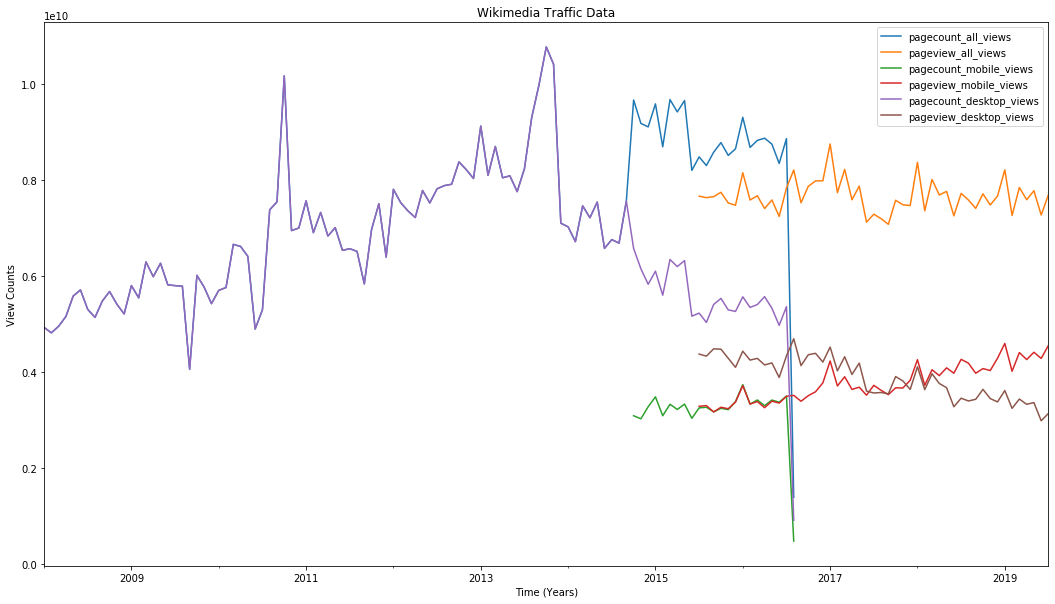

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(18,10))
# gca stands for 'get current axis'
ax = plt.gca()

df.plot(kind='line',x='date',y='pagecount_all_views',ax=ax)
df.plot(kind='line',x='date',y='pageview_all_views', ax=ax)
df.plot(kind='line',x='date',y='pagecount_mobile_views',ax=ax)
df.plot(kind='line',x='date',y='pageview_mobile_views', ax=ax)
df.plot(kind='line',x='date',y='pagecount_desktop_views',ax=ax)
df.plot(kind='line',x='date',y='pageview_desktop_views', ax=ax)
plt.xlabel('Time (Years)')
plt.ylabel('View Counts')
plt.title(label="Wikimedia Traffic Data")

plt.show()